# Importing libraries

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline 
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [2]:
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

In [3]:
from IPython.display import HTML
style = "<style>svg{width:30% !important;height:30% !important;}</style>"
HTML(style)

# Loading the data & Getting to know the data

In [4]:
train_data = pd.read_csv('../input/titanic/train.csv')
test_data = pd.read_csv('../input/titanic/test.csv')

In [5]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [7]:
train_data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [8]:
categorical_columns = ['Sex', 'Pclass', 'Embarked']
continous_columns = ['Age', 'Fare', 'SibSp', 'Parch']

**Categorical columns visualization**

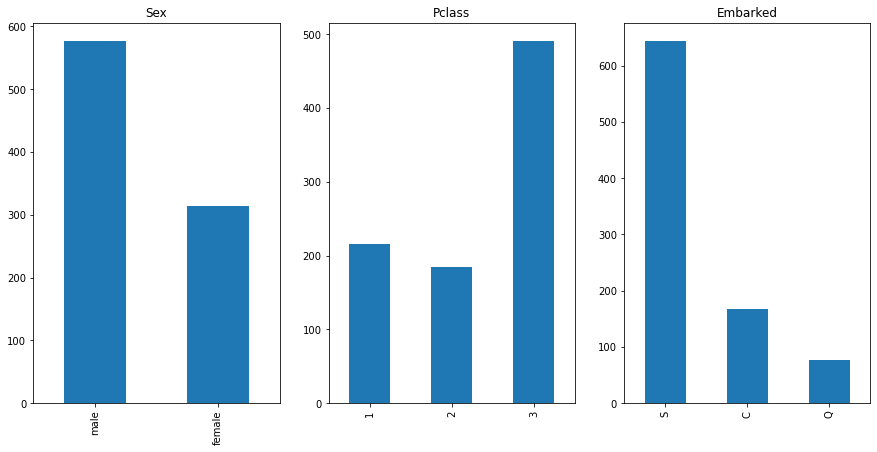

In [9]:
def categorical_columns_visualizing(cols):
    """function which builds and visualizes plot of categorical data"""
    plt.figure(figsize=(15, 7))
    for i,col in enumerate(cols, 1):
        plt.subplot(1, 3, i)
        train_data[col].value_counts().plot.bar()
        plt.title(col)


categorical_columns_visualizing(categorical_columns)

**Continous columns visuaization**

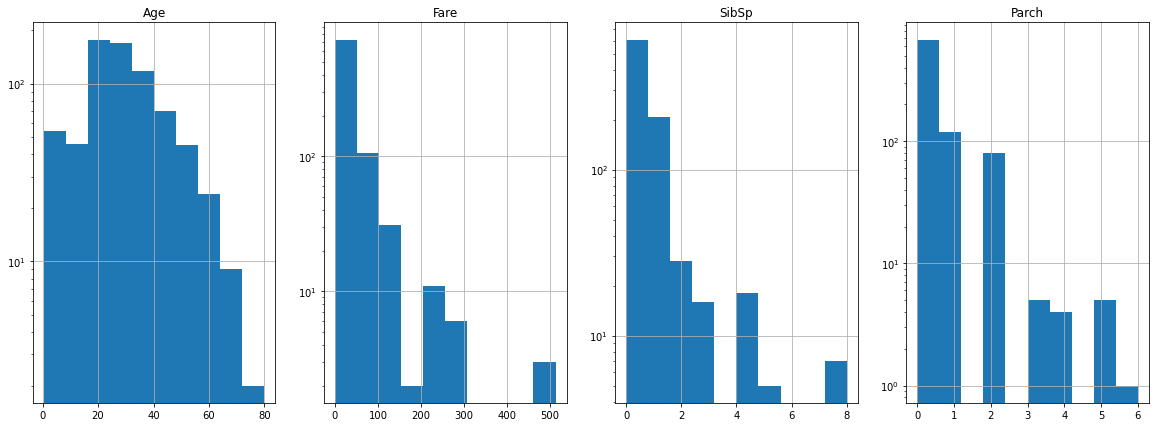

In [10]:
def continous_columns_visualizing(cols):
    """function which builds and visualizes plot of continous data"""
    plt.figure(figsize=(20, 7))
    for i,col in enumerate(cols, 1):
        plt.subplot(1, 4, i)
        train_data[col].hist(log=True)
        plt.title(col)
        
        
continous_columns_visualizing(continous_columns)

# Data preprocessing

In [11]:
def titanic_data_preprocess(df):
    """function which makes data cleaning and feature engineering for titanic dataset"""
    
    if 'Survived' in df.columns:
        df = df.drop('Survived', axis=1)
    
    df = df.drop(['PassengerId', 'Ticket', 'Cabin'], axis=1)
    
    if df.isnull().sum().Fare > 0: 
        df['Fare'].fillna(df[df['Pclass'] == df[df['Fare'].isnull()]['Pclass'].values[0]]['Fare'].median(), inplace=True)
        
    
    def cleaning(group):
        return group.fillna(group.mean())
    
    
    grouped = df.groupby(['Pclass', 'Sex'])
    df['Age'] = grouped['Age'].transform(cleaning)
    
    df['Family_size'] = df['SibSp'] + df['Parch'] + 1
    df['Is_alone'] = (df['Family_size'] <= 1).astype(int)
    
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    df['Title'].replace({'Ms':'Miss', 'Mlle':'Miss', 'Mme':'Mrs'}, inplace=True)
    df['Title'].replace(['Dr', 'Rev', 'Col', 'Major', 'Jonkheer', 'Countess', 'Lady', 'Don', 'Capt', 'Sir'],
                        'Special', inplace=True)
    
    df = df.drop(['Family_size', 'Name'], axis=1)
    
    df = pd.get_dummies(df, columns=['Pclass', 'SibSp', 'Parch', 'Embarked', 'Sex', 'Title'], drop_first=True)
    
    return df

In [12]:
X = titanic_data_preprocess(train_data)
y = train_data.Survived
X.head()

,Age,Fare,Is_alone,Pclass_2,Pclass_3,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,...,Parch_4,Parch_5,Parch_6,Embarked_Q,Embarked_S,Sex_male,Title_Miss,Title_Mr,Title_Mrs,Title_Special
0,22.0,7.2500,0,0,1,1,0,0,0,0,...,0,0,0,0,1,1,0,1,0,0
1,38.0,71.2833,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,26.0,7.9250,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
3,35.0,53.1000,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4,35.0,8.0500,1,0,1,0,0,0,0,0,...,0,0,0,0,1,1,0,1,0,0


**Data splitting**

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# DecisionTree model hyperparameter optimization

In [14]:
def prediction_auc(X, y_true):
    """function which makes predition on given model and return auc score"""
    y_pred = decision_tree_clf.predict(X)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_true, y_pred)
    result = auc(false_positive_rate, true_positive_rate)
    return result


def plotting(x, list_auc_train, list_auc_test, x_name):
    """function which plots results for train and test data depending on test variable"""
    plt.plot(x, list_auc_train, label='train')
    plt.plot(x, list_auc_test, label='test')
    plt.legend()
    plt.xlabel(x_name)
    plt.ylabel('AUC score')
    plt.show()
    
    
def visualizing_tree(built_tree):
    """function which returns image of tree's structure"""
    graph = Source(tree.export_graphviz(built_tree,
                                    out_file=None,
                                    feature_names=list(X),
                                    class_names=['Died', 'Survived'],
                                    filled=True))
    display(SVG(graph.pipe(format='svg')))

**Tunning max_depth**

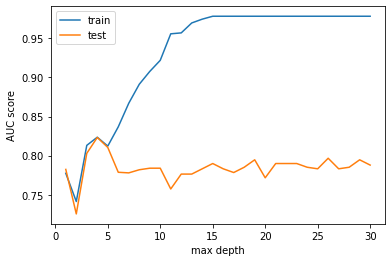

In [15]:
def tunning_max_depth():
    """function which makes tunning of max_depth parametr"""
    global decision_tree_clf
    max_depths = range(1, 31)

    list_auc_train = []
    list_auc_test = []

    for max_depth in max_depths:
        decision_tree_clf = DecisionTreeClassifier(max_depth=max_depth)
        decision_tree_clf.fit(X_train, y_train)
        
        auc_train = prediction_auc(X_train, y_train)
        list_auc_train.append(auc_train)
        
        auc_test = prediction_auc(X_test, y_test)
        list_auc_test.append(auc_test)
    
    return max_depths, list_auc_train, list_auc_test


tunned_max_depth = tunning_max_depth()
plotting(*tunned_max_depth, 'max depth')

**Building tree with max_depth=4**

In [16]:
def building_tree_with_chosen_max_depth(max_depth):
    """function which builds decision tree with chosen max_depth"""
    decision_tree_clf_with_chosen_max_depth = DecisionTreeClassifier(max_depth=max_depth)
    decision_tree_clf_with_chosen_max_depth.fit(X_train, y_train)
    
    y_pred = decision_tree_clf_with_chosen_max_depth.predict(X_test)
    
    false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_pred)
    
    result = auc(false_positive_rate, true_positive_rate)
    
    return result, decision_tree_clf_with_chosen_max_depth


auc_score, built_tree = building_tree_with_chosen_max_depth(max_depth=4)
print('AUC score:', auc_score)

AUC score: 0.8232303732303732


**Tree visualizing**

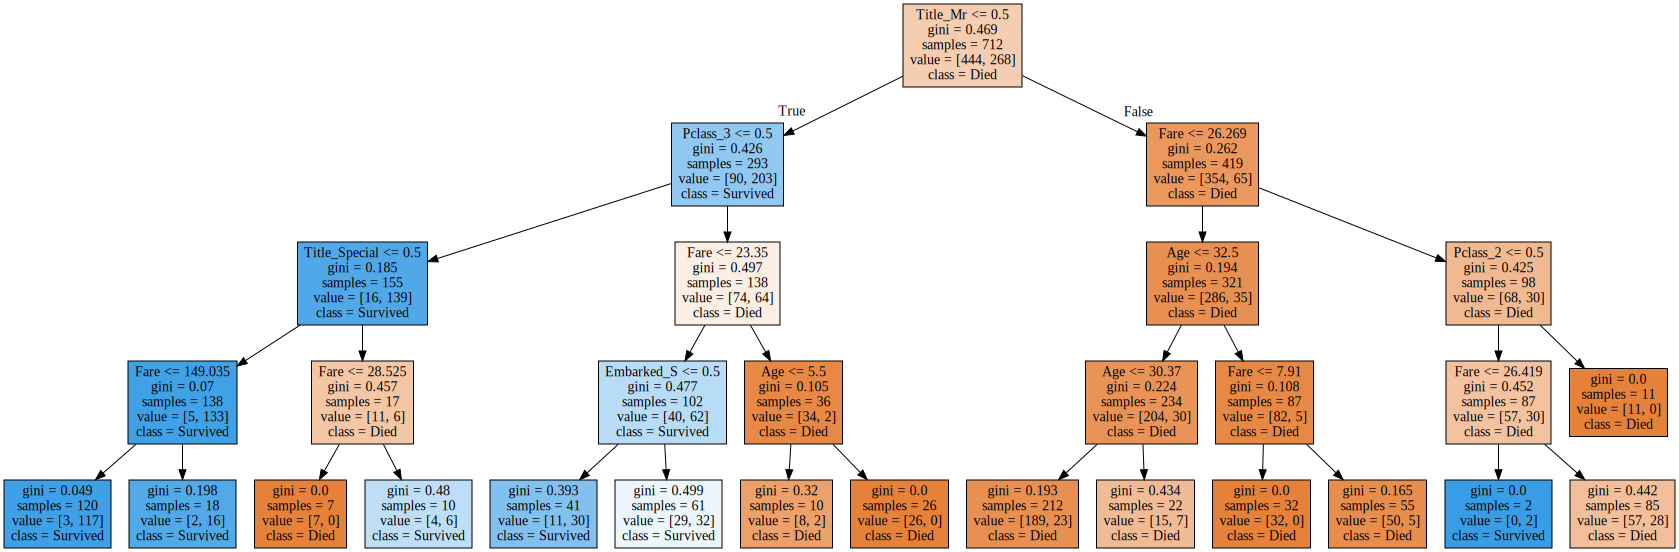

In [17]:
visualizing_tree(built_tree)

**Tunning min_samples_split**

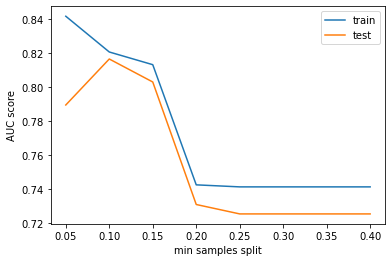

In [18]:
def tunning_min_samples_split():
    """functiob which makes tunning of min_samples_split parametr"""
    global decision_tree_clf
    min_samples_splits = np.linspace(0.05, 0.4, 8)
    
    list_auc_train = []
    list_auc_test = []
    
    for min_samples_split in min_samples_splits:
        decision_tree_clf = DecisionTreeClassifier(min_samples_split=min_samples_split)
        decision_tree_clf.fit(X_train,y_train)
        
        auc_train = prediction_auc(X_train,y_train)
        list_auc_train.append(auc_train)

        auc_test = prediction_auc(X_test,y_test)
        list_auc_test.append(auc_test)
        
    return min_samples_splits, list_auc_train, list_auc_test
    

tunned_min_samples_split = tunning_min_samples_split()
plotting(*tunned_min_samples_split, 'min samples split')

**Building tree with min_samples_split**

In [19]:
def building_tree_with_chosen_min_samples_split(min_samples_split):
    """function which builds decision tree with chosen min_samples_split"""
    decision_tree_clf_with_chosen_min_samples_split = DecisionTreeClassifier(min_samples_split=min_samples_split)
    decision_tree_clf_with_chosen_min_samples_split.fit(X_train, y_train)
    
    y_pred = decision_tree_clf_with_chosen_min_samples_split.predict(X_test)
    
    false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_pred)
    
    result = auc(false_positive_rate, true_positive_rate)
    
    return result, decision_tree_clf_with_chosen_min_samples_split


auc_score, built_tree = building_tree_with_chosen_min_samples_split(min_samples_split=0.1)
print('AUC score:', auc_score)

AUC score: 0.8164736164736165


**Tree visualizing**

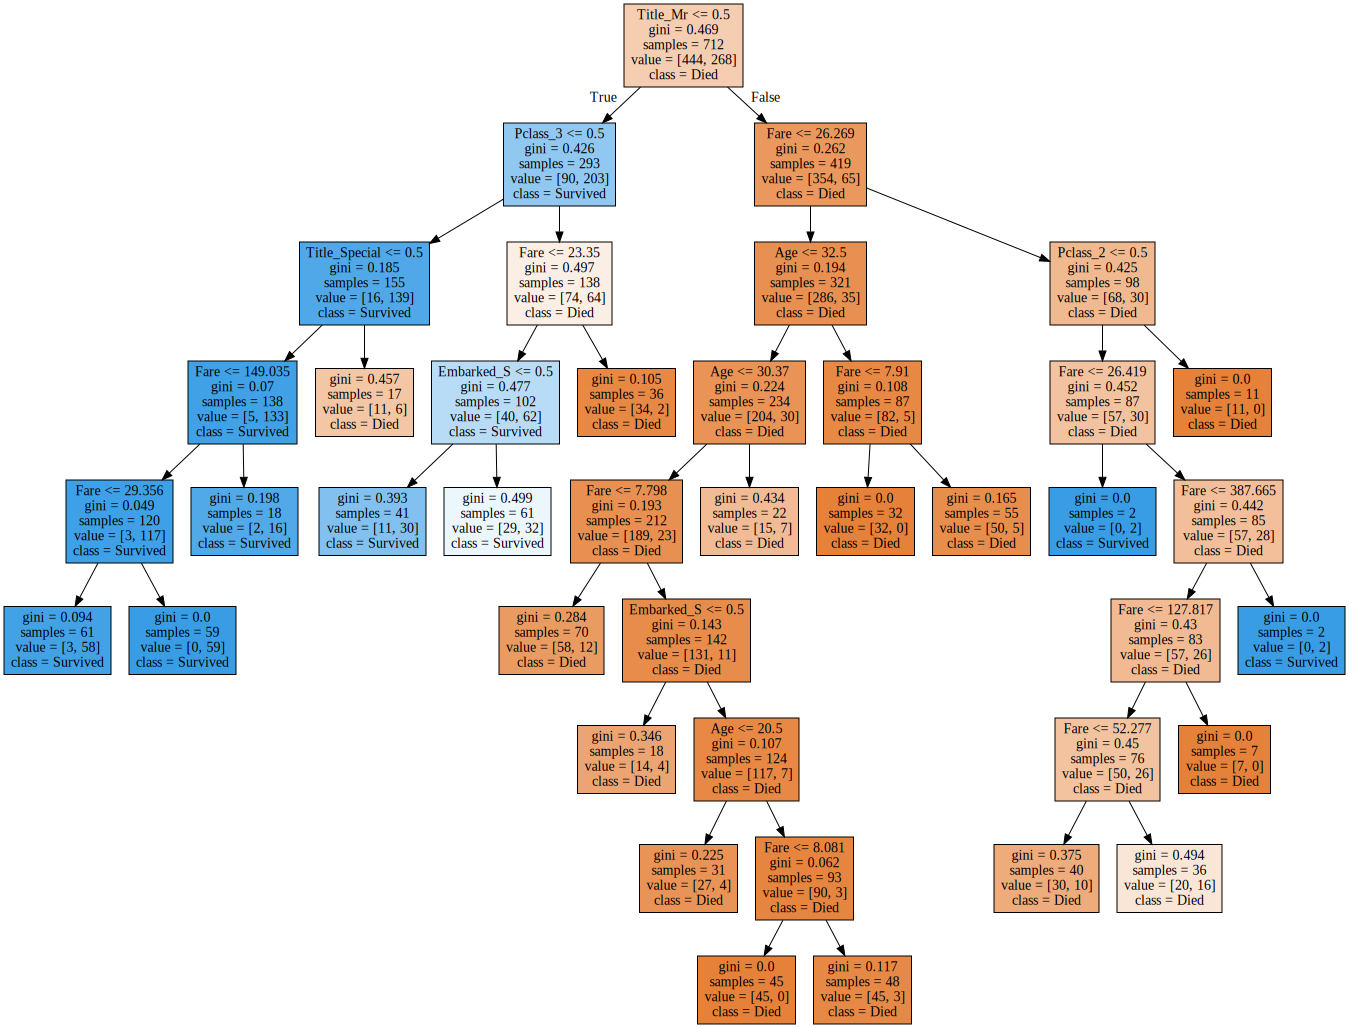

In [20]:
visualizing_tree(built_tree)

**Tunning min_samples_leaf**

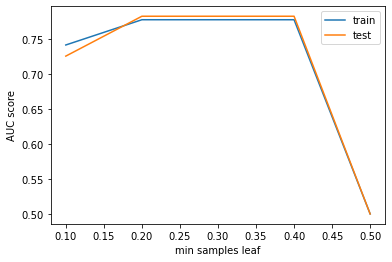

In [21]:
def tunning_min_samples_leaf():
    """functiob which makes tunning of min_samples_leaf parametr"""
    global decision_tree_clf
    min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
    
    list_auc_train = []
    list_auc_test = []
    
    for min_samples_leaf in min_samples_leafs:
        decision_tree_clf = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
        decision_tree_clf.fit(X_train,y_train)
        
        auc_train = prediction_auc(X_train,y_train)
        list_auc_train.append(auc_train)

        auc_test = prediction_auc(X_test,y_test)
        list_auc_test.append(auc_test)
        
    return min_samples_leafs, list_auc_train, list_auc_test
    

tunned_min_samples_leaf = tunning_min_samples_leaf()
plotting(*tunned_min_samples_leaf, 'min samples leaf')

**Building tree with min_samples_leaf**

In [22]:
def building_tree_with_chosen_min_samples_leaf(min_samples_leaf):
    """function which builds decision tree with chosen min_samples_leaf"""
    decision_tree_clf_with_chosen_min_samples_leaf = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
    decision_tree_clf_with_chosen_min_samples_leaf.fit(X_train, y_train)
    
    y_pred = decision_tree_clf_with_chosen_min_samples_leaf.predict(X_test)
    
    false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_pred)
    
    result = auc(false_positive_rate, true_positive_rate)
    
    return result, decision_tree_clf_with_chosen_min_samples_leaf


auc_score, built_tree = building_tree_with_chosen_min_samples_leaf(min_samples_leaf=0.2)
print('AUC score:', auc_score)

AUC score: 0.7823680823680824


**Tree visualizing**

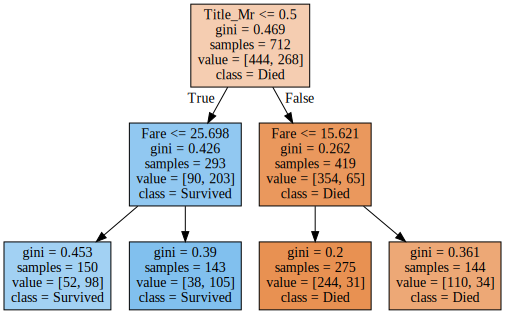

In [23]:
visualizing_tree(built_tree)

# RandomForest model hyperparameter optimization

In [24]:
def optimizing_random_forest_hyperparameters_randomized_search_cv():
    """function which finds the most suitable hyperparameters for RandomForest model"""
    random_forest_clf = RandomForestClassifier()
    
    n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
    max_features = ['log2', 'sqrt']
    max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
    min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
    min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
    bootstrap = [True, False]
    
    param_dist = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    
    rsc = RandomizedSearchCV(random_forest_clf, 
                             param_dist, 
                             n_iter=100, 
                             cv=3, 
                             verbose=1, 
                             n_jobs=-1, 
                             random_state=0)

    rsc.fit(X_train, y_train)
    random_forest_best_params_rsc = rsc.best_params_
    
    return random_forest_best_params_rsc, rsc


best_params_rsc, rsc = optimizing_random_forest_hyperparameters_randomized_search_cv()

Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [25]:
best_params_rsc

{'n_estimators': 700,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'log2',
 'max_depth': 11,
 'bootstrap': True}

In [26]:
def randomized_search_cv_results():
    """function which shows results of RandomizedSearchCV algorithm work"""
    rsc_df = pd.DataFrame(rsc.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
    
    rsc_df = rsc_df.drop([
                'mean_fit_time', 
                'std_fit_time', 
                'mean_score_time',
                'std_score_time', 
                'params', 
                'split0_test_score', 
                'split1_test_score', 
                'split2_test_score', 
                'std_test_score'],
                axis=1)
    
    randomized_search_cv_results = rsc_df
    
    return randomized_search_cv_results, rsc

    
randomized_search_cv_results, rsc = randomized_search_cv_results()
randomized_search_cv_results.head(10)

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,mean_test_score,rank_test_score
0,700,2,2,log2,11,True,0.828671,1
1,700,12,2,sqrt,13,False,0.825858,2
2,400,23,2,sqrt,14,False,0.823045,3
3,700,23,7,log2,15,False,0.823039,4
4,600,23,2,sqrt,15,False,0.820238,5
5,600,50,2,sqrt,7,False,0.820226,6
6,700,18,7,sqrt,7,False,0.820226,6
7,500,18,7,log2,7,True,0.816024,8
8,300,28,7,log2,13,True,0.816018,9
9,1000,44,2,sqrt,9,True,0.816012,10


**RandomizedSearchCV result visualizing**

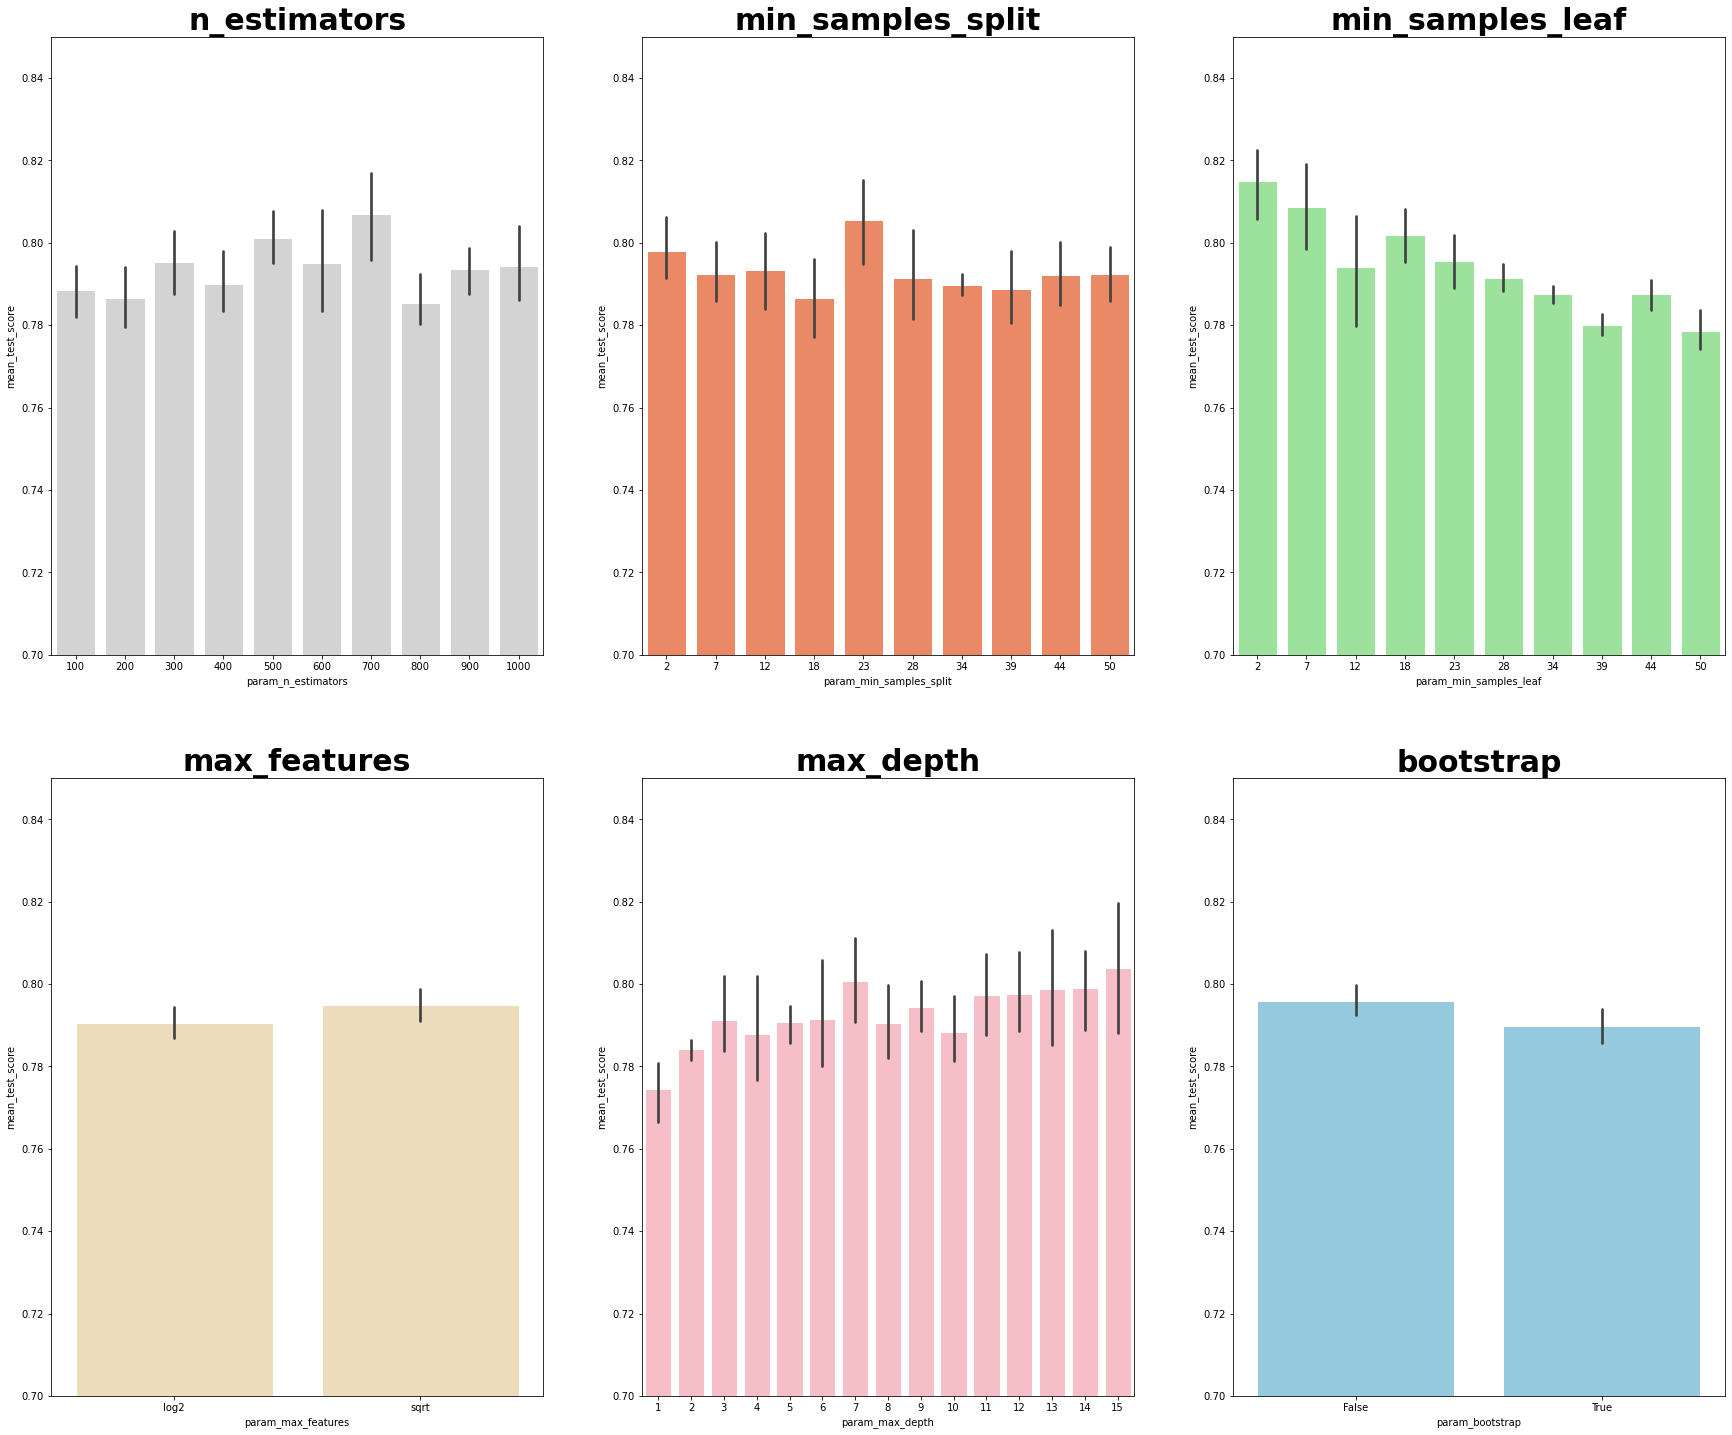

In [27]:
def visualizing_randomized_search_cv_results():
    fig, axs = plt.subplots(ncols=3, nrows=2)
    
    sns.set(style="whitegrid", color_codes=True, font_scale = 2)
    
    fig.set_size_inches(30,25)
    
    x_params = ['param_n_estimators',
                'param_min_samples_split',
                'param_min_samples_leaf',
                'param_max_features',
                'param_max_depth',
                'param_bootstrap']
    colors = ['lightgrey',
              'coral',
              'lightgreen',
              'wheat',
              'lightpink',
              'skyblue']
    coords_1, coords_2 = [0, 0, 0, 1, 1, 1], [0, 1, 2, 0, 1, 2]
    
    for x, color, coord_1, coord_2 in zip(x_params, colors, coords_1, coords_2):
        sns.barplot(x=x,
                    y='mean_test_score',
                    data=randomized_search_cv_results,
                    ax=axs[coord_1,coord_2],
                    color=color)
        
        axs[coord_1,coord_2].set_ylim([.7,.85])
        axs[coord_1,coord_2].set_title(label = x[6:], size=30, weight='bold')
    
    plt.show()

    
visualizing_randomized_search_cv_results()

**Final preparation of parameters for the model**

In [28]:
gs_best_params

NameError: name 'gs_best_params' is not defined

In [29]:
def optimizing_random_forest_hyperparameters_grid_search_cv():
    """function which optimizes RandomForest model hyperparametrs using GridSearchCV"""
    random_forest_clf = RandomForestClassifier()
    n_estimators = [300,500,700]
    max_features = ['sqrt']
    max_depth = [3,7,11,13,14,15]
    min_samples_split = [2,7,12,23,28,44]
    min_samples_leaf = [2,7,12,18,23,28]
    bootstrap = [False]
    
    param_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}

    gs = GridSearchCV(random_forest_clf,
                      param_grid,
                      cv=3,
                      verbose=1,
                      n_jobs=-1)
    
    gs.fit(X_train, y_train)
    
    return gs


gs = optimizing_random_forest_hyperparameters_grid_search_cv()

gs_best_estimator = gs.best_estimator_
gs_best_params = gs.best_params_

Fitting 3 folds for each of 648 candidates, totalling 1944 fits


**Making best parametrs for classifiers**

In [30]:
# best parametrs for DecisionTree
max_depth_dt = 4
min_samples_split_dt = 0.1
min_samples_leaf_dt = 0.2

# best parametrs for RandomForest
n_estimators = 500
min_samples_split_rf = 7
min_samples_leaf_rf = 2
max_features = 'sqrt'
max_depth_rf = 14
bootstrap = False

**Creating classifier models for analyzing the quality of fitting parameters**

In [31]:
def analysing_quality_fitting_parametrs():
    """function which builds models and makes predictions for analysing the quality of fitting parameters"""
    dt_with_no_params = DecisionTreeClassifier()
    dt_with_params = DecisionTreeClassifier(max_depth=max_depth_dt,
                                            min_samples_split=min_samples_split_dt,
                                            min_samples_leaf=min_samples_leaf_dt)
    rf_with_no_params = RandomForestClassifier()
    rf_with_params = RandomForestClassifier(n_estimators=n_estimators,
                                            min_samples_split=min_samples_split_rf,
                                            min_samples_leaf=min_samples_leaf_rf,
                                            max_features='sqrt',
                                            max_depth=max_depth_rf,
                                            bootstrap=False)
    
    models = [dt_with_no_params,
              dt_with_params,
              rf_with_no_params,
              rf_with_params]
    labels = ['DecisionTree with no parametrs',
              'DecisionTree with parametrs',
              'RandomForest with no parametrs',
              'RandomForest with parametrs']
    
    y_pred_list = []
    
    for model, label in zip(models, labels):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_list.append(y_pred)
    
    return y_pred_list, labels, models


y_pred_list, model_labels, models = analysing_quality_fitting_parametrs()

**Creating error matrices for models**

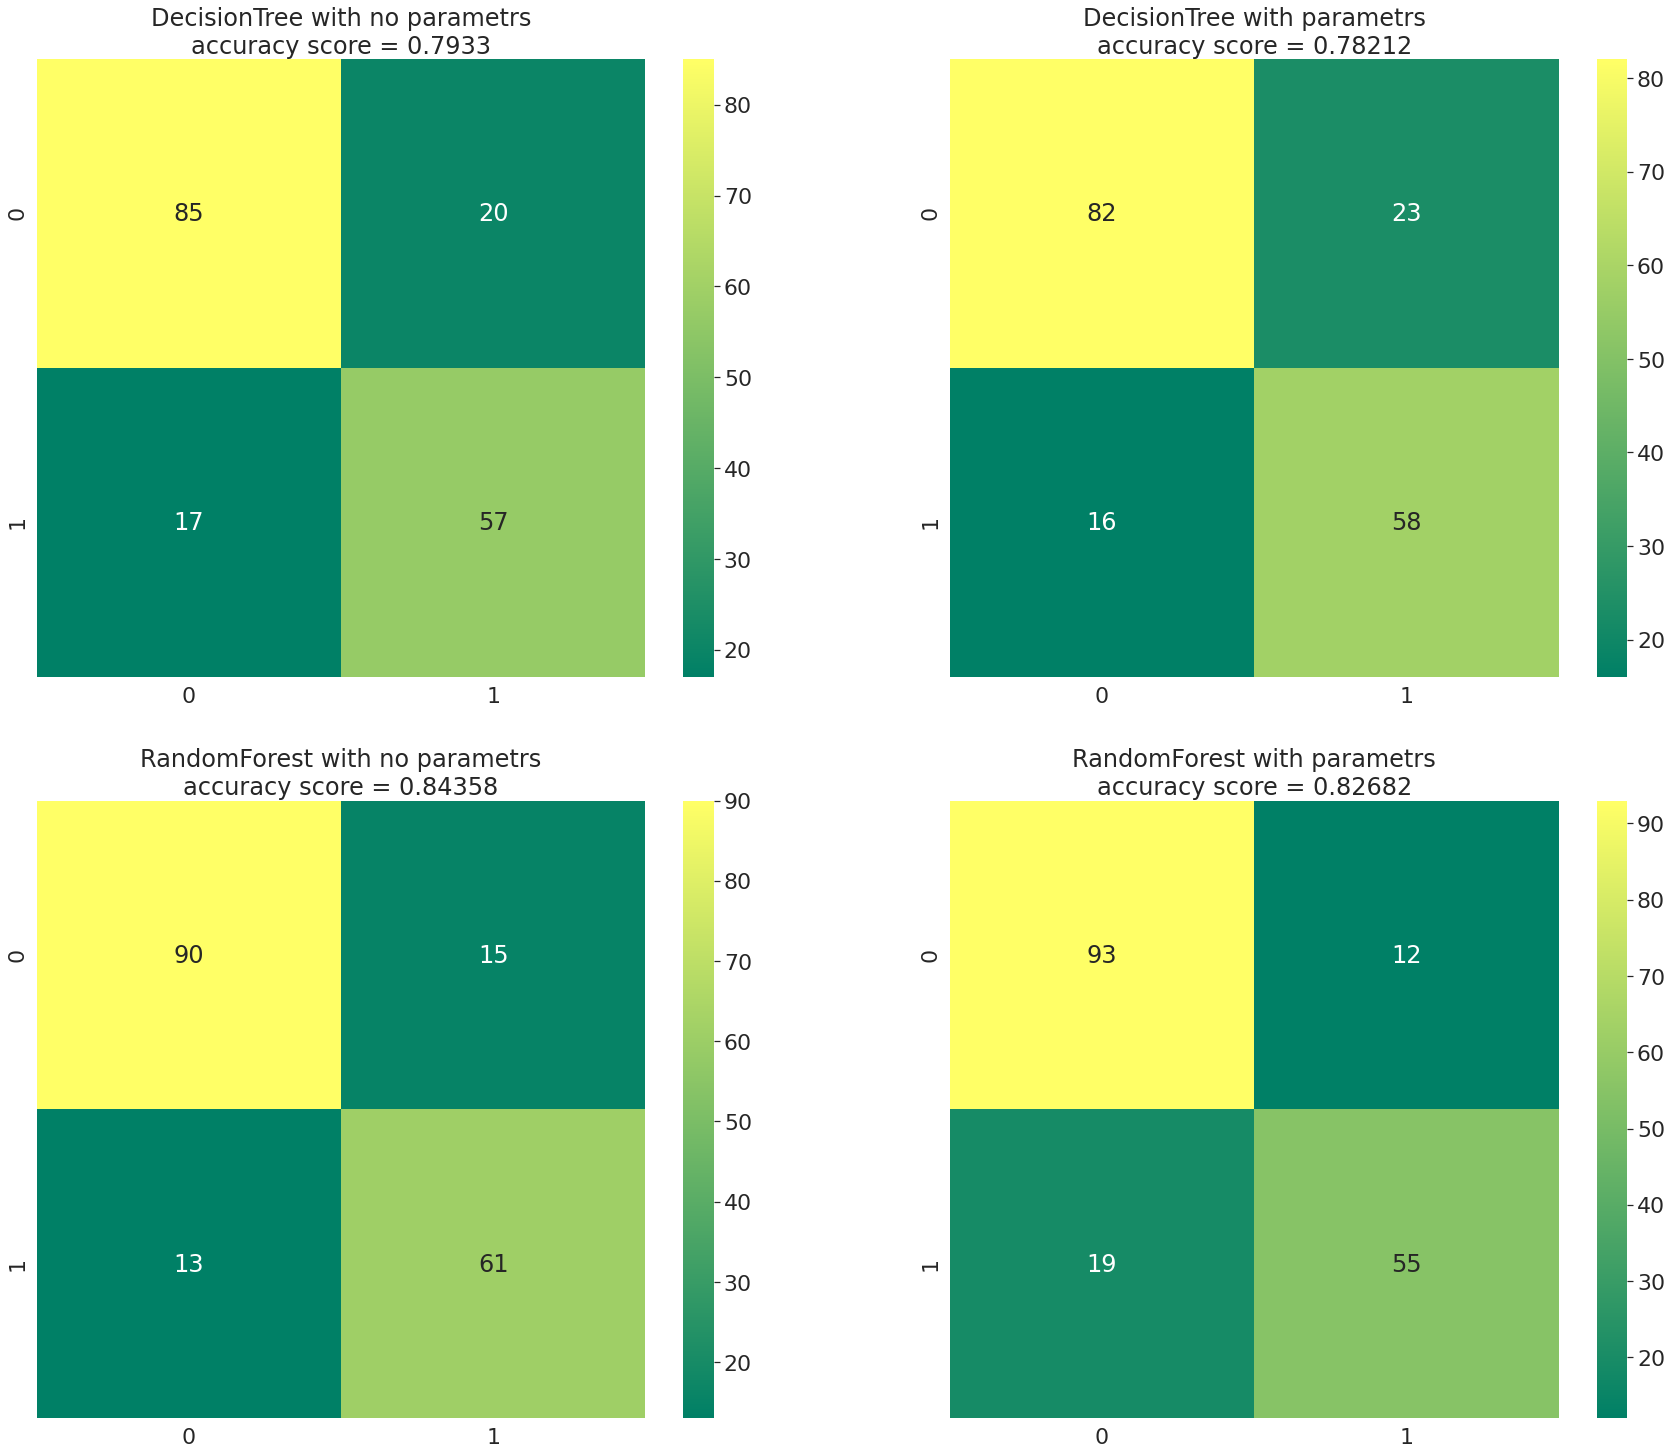

In [32]:
def showing_models_confusion_matrices(y_pred_list, model_labels):
    """function which displays confusion matrices and accuracy score for each model"""
    fig, axs = plt.subplots(2, 2)
    coords_1, coords_2 = (0, 0, 1, 1), (0, 1, 0, 1)
    
    sns.set(style="whitegrid", color_codes=True, font_scale = 2)
    
    fig.set_size_inches(30,25)
    
    for y_pred, model_label, coord_1, coord_2 in zip(y_pred_list, model_labels, coords_1, coords_2):
        conf_matrix = confusion_matrix(y_test, y_pred)
        
        sns.heatmap(conf_matrix, annot=True, cmap='summer', ax=axs[coord_1, coord_2])
        axs[coord_1, coord_2].set_title(model_label +
                                        '\naccuracy score = ' +
                                        str(np.around(accuracy_score(y_test, y_pred), decimals=5)))

    plt.show()
    
    
showing_models_confusion_matrices(y_pred_list=y_pred_list, model_labels=model_labels)

# Building final model

**Going to look at the prediction accuracy of the models with fitted parameters**

In [33]:
dt_final_model = DecisionTreeClassifier(max_depth=max_depth_dt,
                                        min_samples_split=min_samples_split_dt,
                                        min_samples_leaf=min_samples_leaf_dt,
                                        random_state=42)

rf_final_model = RandomForestClassifier(n_estimators=n_estimators,
                                        min_samples_split=min_samples_split_rf,
                                        min_samples_leaf=min_samples_leaf_rf,
                                        max_features='sqrt',
                                        max_depth=max_depth_rf,
                                        bootstrap=False,
                                        random_state=42)

dt_final_model.fit(X_train, y_train)
rf_final_model.fit(X_train, y_train)
y_pred_test_dt = dt_final_model.predict(X_test)
y_pred_test_rf = rf_final_model.predict(X_test)
print(accuracy_score(y_test, y_pred_test_dt),
accuracy_score(y_test, y_pred_test_rf), sep='\n')

0.7821229050279329
0.8324022346368715


In [34]:
def making_the_best_prediction(models, model_labels):
    """function which makes the best prediction based on the accuracy of the predictions made on the test sample"""
    accuracy_list = []
    
    for model in models:
        final_model = model.fit(X_train, y_train)
        y_pred_final_model = model.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred_final_model)
        accuracy_list.append(accuracy)
    
    highest_accuracy_value = max(accuracy_list)
    index_of_highest_accuracy_value = accuracy_list.index(highest_accuracy_value)
    best_model = models[index_of_highest_accuracy_value]
    best_model_label = model_labels[index_of_highest_accuracy_value]
    
    return highest_accuracy_value, best_model, best_model_label


highest_accuracy_value, best_model, best_model_label = making_the_best_prediction(models=models, model_labels=model_labels)

In [35]:
print('Best model:\n', best_model_label + ' has ', highest_accuracy_value, ' accuracy score', sep='')

Best model:
RandomForest with no parametrs has 0.8324022346368715 accuracy score


# Making final prediction using RandomForestClassifier fitted by parameters

**Going to preprocess test data**

In [36]:
X_to_be_predicted = titanic_data_preprocess(test_data)
print(X.columns, X_to_be_predicted.columns, sep='\n')

Index(['Age', 'Fare', 'Is_alone', 'Pclass_2', 'Pclass_3', 'SibSp_1', 'SibSp_2',
       'SibSp_3', 'SibSp_4', 'SibSp_5', 'SibSp_8', 'Parch_1', 'Parch_2',
       'Parch_3', 'Parch_4', 'Parch_5', 'Parch_6', 'Embarked_Q', 'Embarked_S',
       'Sex_male', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Special'],
      dtype='object')
Index(['Age', 'Fare', 'Is_alone', 'Pclass_2', 'Pclass_3', 'SibSp_1', 'SibSp_2',
       'SibSp_3', 'SibSp_4', 'SibSp_5', 'SibSp_8', 'Parch_1', 'Parch_2',
       'Parch_3', 'Parch_4', 'Parch_5', 'Parch_6', 'Parch_9', 'Embarked_Q',
       'Embarked_S', 'Sex_male', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Special'],
      dtype='object')


**Removing features that are not in the training sample**

In [37]:
X_to_be_predicted = X_to_be_predicted.drop(['Parch_9', 'Title_Master'], axis=1)

**Making prediction**

In [38]:
def making_submission(best_model, X_to_be_predicted):
    """function which makes prediction"""
    result = best_model.predict(X_to_be_predicted)
    
    submission = pd.DataFrame({'PassengerId':test_data.PassengerId,
                               'Survived': result})
    
    submission.Survived = submission.Survived.astype(int)
    submission.to_csv('sub2.csv', index=False)
    
    return submission


submission = making_submission(best_model=best_model, X_to_be_predicted=X_to_be_predicted)
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,1
